In [78]:
import pandas as pd 


import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
sns.set()

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from scipy.stats import boxcox

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
original = pd.read_csv("D:/Téléchargements/en.openfoodfacts.org.products.tsv",
                       delimiter='\t',
                       encoding='utf-8')
original.head()

D:\YNOV\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning:

Columns (0,3,5,19,20,24,25,26,27,28,36,37,38,39,48) have mixed types.Specify dtype option on import or set low_memory=False.



,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,4559,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,16087,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,16094,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
def make_word_cloud(data, cluster, subplotax, title):
    words = data[data.cluster==cluster]["product"].apply(lambda l: l.lower().split())
    cluster_words=words.apply(pd.Series).stack().reset_index(drop=True)
    frequencies = cluster_words.value_counts()
    
    text = " ".join(w for w in cluster_words)

    # Create and generate a word cloud image:
    wordcloud = WordCloud(max_font_size=40, max_words=30,
                          background_color="white", colormap="magma")
    wordcloud.generate_from_frequencies(frequencies)
    # Display the generated image:
    subplotax.imshow(wordcloud, interpolation='bilinear')
    subplotax.axis("off")
    subplotax.set_title(title)
    return subplotax

In [80]:
df = pd.DataFrame(original)

df.shape

(356027, 163)

On retire les colonnes qui ont moins de 30% de données, puis on garde que les colonnes de type float afin de pouvoir entrainer un modèle à partir d'un jeu de données propre

In [81]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
newDataFrame = df.drop((missing_data[missing_data['Percent'] > 0.3]).index, 1)
cleaned_data = pd.DataFrame(newDataFrame.select_dtypes(['number']))
#cleaned_data.dropna(cleaned_data.columns.values, inplace=True)
cleaned_data = cleaned_data.dropna()
#cleaned_data.shape

In [82]:
#original.head()
cleaned_data.head()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
1,0.0,0.0,0.0,2243.0,28.57,28.57,64.29,14.29,3.57,0.00000,0.000,14.0,14.0
2,0.0,0.0,0.0,1941.0,17.86,0.00,60.71,17.86,17.86,0.63500,0.250,0.0,0.0
3,0.0,0.0,0.0,2540.0,57.14,5.36,17.86,3.57,17.86,1.22428,0.482,12.0,12.0
7,1.0,0.0,0.0,1833.0,18.75,4.69,57.81,15.62,14.06,0.13970,0.055,7.0,7.0
12,0.0,0.0,0.0,2230.0,36.67,5.00,36.67,3.33,16.67,1.60782,0.633,12.0,12.0


In [83]:
train_table, test_table = train_test_split(cleaned_data, test_size=0.3, random_state=0)

In [84]:
X_train = train_table.values
X_test = test_table.values

In [85]:
print("Number of train samples: " + str(X_train.shape[0]))

Number of train samples: 160190


In [86]:
kmeans = KMeans(
    init="random",
    n_clusters=20,
    n_init=10,
    max_iter=300,
    random_state=42
)
kmeans.fit(X_train)

train_table["cluster"] = kmeans.predict(X_train)
test_table["cluster"] = kmeans.predict(X_test)
train_table["product"] = original.loc[train_table.index, "product_name"]

D:\YNOV\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\YNOV\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\YNOV\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

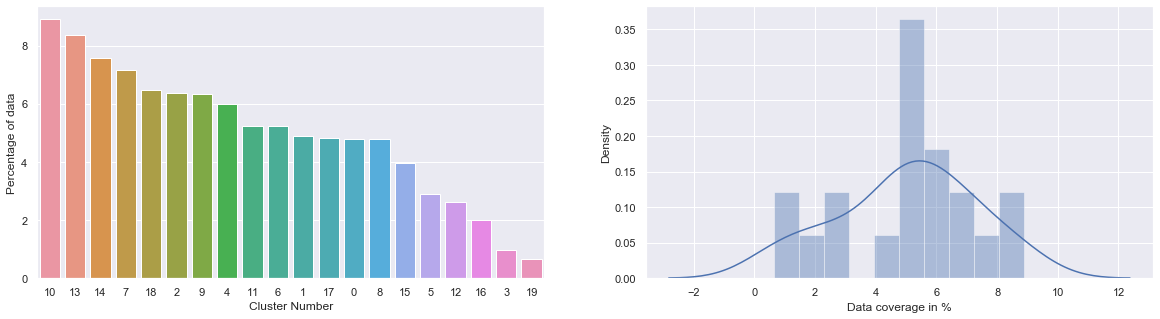

In [104]:
cluster_count = train_table.cluster.value_counts()

fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.barplot(x=cluster_count.index,
            y=cluster_count.values / train_table.shape[0] * 100,
            order=cluster_count.index, ax=ax[0])
ax[0].set_xlabel("Cluster Number")
ax[0].set_ylabel("Percentage of data")
sns.distplot(cluster_count.values / train_table.shape[0] * 100, bins=10, ax=ax[1])
ax[1].set_xlabel("Data coverage in %")
ax[1].set_ylabel("Density");

def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(16, 9))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

In [88]:
train_table

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,cluster,product
108646,1.0,0.0,0.0,222.0,0.00,0.00,14.04,11.40,0.00,0.00000,0.000000,2.0,2.0,10,Crushed Pineapple In Pineapple Juice
304456,2.0,0.0,1.0,2200.0,31.20,19.60,54.70,45.10,6.90,0.16764,0.066000,26.0,26.0,15,Chocolat au lait croustillant
150606,0.0,0.0,0.0,837.0,0.71,0.00,44.29,0.00,5.71,2.17678,0.857000,10.0,10.0,2,Risotto Milanese
75241,0.0,0.0,0.0,1046.0,17.86,10.71,3.57,3.57,21.43,1.81356,0.714000,20.0,20.0,14,Part-Skim Mozzarella Cheese
82176,0.0,0.0,0.0,473.0,1.50,0.00,18.00,14.00,6.00,1.12522,0.443000,0.0,0.0,9,Kitni All Natural Chick Peas
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245401,2.0,0.0,0.0,536.0,3.00,1.20,1.00,1.00,24.00,5.00000,1.968504,12.0,12.0,6,Jambon Cru Fumé
152145,3.0,0.0,0.0,1494.0,1.79,0.00,73.21,3.57,12.50,0.00000,0.000000,-6.0,-6.0,13,Rigatoni Pasta
239514,0.0,0.0,0.0,2989.0,80.00,49.00,1.00,1.00,0.70,2.00000,0.787402,25.0,26.0,3,Beurre de Baratte demi-sel
55921,3.0,0.0,0.0,1117.0,6.67,1.33,49.33,4.00,5.33,0.98298,0.387000,0.0,0.0,14,White Hot Dog Buns


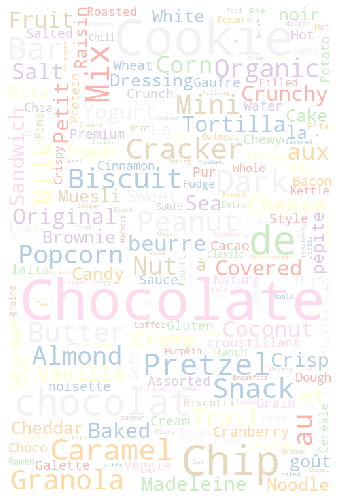

In [105]:
i = 0
wordcloud = WordCloud(width = 500, height = 750, random_state=1, background_color='white', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(train_table.loc[train_table['cluster'] == i, ['product']].to_string())
plot_cloud(wordcloud)

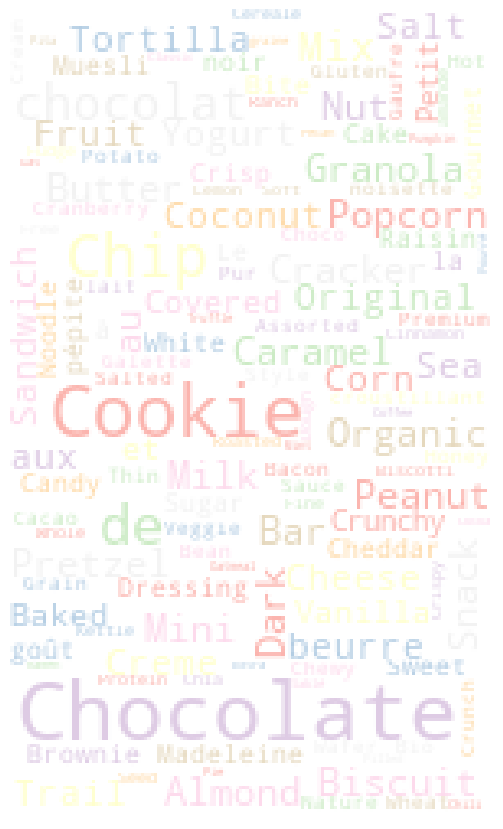

In [90]:
plot_cloud(wordcloud)